In [1]:
!pip install sentencepiece
!pip install wget
!pip install konlpy
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
import os
import json
import pandas as pd
import wget
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json
import torchtext
import konlpy
from konlpy.tag import Mecab
from IPython.display import display
import sentencepiece as spm
tagger = Mecab()
from tqdm import tqdm, tqdm_notebook, trange
from torchtext.data import Field, BucketIterator, TabularDataset, Dataset
import os
import tqdm

from google.colab import drive
drive.mount('/content/gdrive')

# import tqdm

%matplotlib inline
torch.cuda.get_device_name(0)
data_dir = '/content/gdrive/My Drive/Colab Notebooks/study_dataset' # Data Path
for f in os.listdir(data_dir):
  print(f)


mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
kowiki.model
kowiki.vocab
kowiki.txt
kowiki_bert_0.json
kowiki_gpt.json
ratings_test.json
ratings_test.txt
ratings_train.json
ratings_train.txt
save_bert_pretrain.pth
kowiki.csv.gz
save_gpt_pretrain.pth


In [0]:
# GPT Model
# class Embedding(nn.Module):
#     def __init__(self, n_vocab, d_model):
#         super().__init__()
#         self.embed = nn.Embedding(n_vocab, d_model)
#         self.Pos_emb = nn.Embedding(n_vocab, d_model)
#     def forward(self,x):
#         pos_emb = self.Pos_emb(torch.arange(0,x.shape[1]).repeat(x.shape[0],1).to('cuda'))
#         return self.embed(x)+pos_emb
class Embedding(nn.Module):
    def __init__(self, n_vocab, d_model):
        super().__init__()
        self.embed = nn.Embedding(n_vocab, d_model)
    def forward(self,x):
        return self.embed(x)

# Sinusoid vector
def Get_Sinusoid_Table(seq_n, d_model):
    def cal_angle(position, i_hidden):
        return position / np.power(10000, 2 * (i_hidden // 2) / d_model)
    def get_pos_angle_vec(pos):
        return [cal_angle(pos, i_hidden) for i_hidden in range(d_model)]
    
    sinusoid_table = np.array([get_pos_angle_vec(i_seq) for i_seq in range(seq_n)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

# Add Sinusoid & Embedding
def Add_Positional_Embedding(inputs, Input_Embedding, d_model):
    seq_n = Input_Embedding.size()[1]
    pos_encoding = torch.FloatTensor(Get_Sinusoid_Table(seq_n, d_model)) # positional embedding vec
    nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=False).to(device)
    
    positions = torch.arange(inputs.size(1), dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous().to(device)
    
    pos_mask = inputs.eq(0)
    positions.masked_fill_(pos_mask, 0)
    pos_embs = nn_pos(positions) # position embedding

    out = Input_Embedding + pos_embs
    return out

def GetMultiHeadMask(inputs, enc_input_QWi, enc_input_KWi): # GetEncoderMask
    if (len(enc_input_QWi.size())<4):
        print("Encoder QWi dim is not 4, (batch, seq, n_head, hidden/n_head)")
        return

    pad_mask = inputs.eq(0).unsqueeze(1).expand(enc_input_QWi.size(0), enc_input_QWi.size(1), enc_input_QWi.size(2))
    EncMask = pad_mask.unsqueeze(2).repeat(1, 1, enc_input_KWi.size()[2], 1)

    return EncMask

def GetMaskedMultiHeadMask(dec_inputs, dec_input_QWi, dec_input_KWi): # GetDecoderMask
    if (len(dec_input_QWi.size())<4):
        print("dec QWi dim is not 4, (batch, seq, n_head, hidden/n_head)")
        return
    np_tri_mask = np.triu(np.ones((dec_inputs.size()[0],dec_input_QWi.size()[1],dec_input_QWi.size()[2],dec_input_KWi.size()[2])),k=1).astype('uint8')
    tri_mask = torch.from_numpy(np_tri_mask).to(device)
    pad_mask = dec_inputs.eq(0).unsqueeze(1).expand(dec_input_QWi.size(0), dec_input_QWi.size(1), dec_input_KWi.size(2))
    pad_mask = pad_mask.unsqueeze(2).repeat(1, 1, dec_input_QWi.size()[2], 1)
    DecMask = torch.add(tri_mask>0, pad_mask==True)
    return DecMask

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, Q, K, V, attn_mask):
        score_mat = torch.matmul(Q,K.transpose(-1,-2)).mul_(1/Q.size()[-1]**0.5)
        score_mat_attn = score_mat.masked_fill_(attn_mask, -1e9)
        score_mat_prob = nn.Softmax(dim=-1)(score_mat_attn)
        head_i = torch.matmul(score_mat_prob, V)
        return head_i
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, dropout = 0.1):
        super().__init__()
        #self.d_k = d_model // n_head        
        # 512 Linear -> separate 64 * n_head
        self.W_Q_linear = nn.Linear(d_model, d_model) 
        self.W_K_linear = nn.Linear(d_model, d_model)
        self.W_V_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.W_O_linear = nn.Linear(d_model, d_model)
        
    def forward(self, enc_inputs, dec_inputs, Q, K, V, n_head, Encoder=True, MaskedMultiHead=False):
        batch_size = Q.size()[0]
        
        # perform linear operation and split into h heads        
        QWi_Q = self.W_Q_linear(Q).view(batch_size, -1, n_head, int(d_model/n_head)).transpose(1,2).to(device)
        KWi_K = self.W_K_linear(K).view(batch_size, -1, n_head, int(d_model/n_head)).transpose(1,2).to(device)
        VWi_V = self.W_V_linear(V).view(batch_size, -1, n_head, int(d_model/n_head)).transpose(1,2).to(device)
        
        if Encoder == True:
            EncMask = GetMultiHeadMask(enc_inputs, QWi_Q, KWi_K)
            Mask = EncMask
        else: # make Decoder mask
            if MaskedMultiHead == False:
                DecMask = GetMultiHeadMask(enc_inputs, KWi_K, QWi_Q)
            else:
                DecMask = GetMaskedMultiHeadMask(dec_inputs, QWi_Q, KWi_K)
            Mask = DecMask
        # Scaled dot product attention -> head_i
        head_i = ScaledDotProductAttention()(QWi_Q, KWi_K, VWi_V, Mask)
        
        # concatenat heads
        concat = head_i.transpose(1, 2).contiguous().view(batch_size, QWi_Q.size()[2], d_model)
        # concat * W_O
        output = self.W_O_linear(concat)
    
        return output
    
class Normalization(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()    
        self.size = d_model
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm
    
class FeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_model*4)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_model*4, d_model)
    def forward(self, input_tensor):
        x = self.dropout(F.gelu(self.linear1(input_tensor)))
        out_tensor = self.linear2(x)
        return out_tensor

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, n_vocab, dropout=0.1):
        super().__init__()
        
        self.MultiHeadAtt = MultiHeadAttention(d_model)
        self.Norm = nn.LayerNorm(d_model, eps=1e-12)#Normalization(d_model)
        self.Norm2 = nn.LayerNorm(d_model, eps=1e-12)
        self.ff = FeedForward(d_model)
        self.d_model = d_model
        self.n_head = n_head
    def forward(self, dec_word, emb_dec_word):
        x = emb_dec_word
        x = x + self.MultiHeadAtt(dec_word, dec_word, x, x, x, self.n_head, Encoder=False, MaskedMultiHead=True) # Masked Multi Head Att
        x = self.Norm(x) # Norm

        x = x + self.ff(x)
        x = self.Norm2(x) # Norm
        return x
    
class Decoder(nn.Module):
    def __init__(self, d_model, n_head, n_vocab, N=12, dropout=0.1):
        super().__init__()
        self.embed = Embedding(n_vocab, d_model)
        self.d_model = d_model
        self.dec_layer = nn.ModuleList([DecoderLayer(d_model, n_head=n_head, n_vocab=n_vocab, dropout=dropout) for _ in range(N)])
        
    def forward(self, dec_word):
#         word = dec_word
        emb_word = self.embed(dec_word)
        pos_emb_word = Add_Positional_Embedding(dec_word, emb_word, self.d_model)
        
        x = pos_emb_word
        
        for layer in self.dec_layer:
            x = layer(dec_word, x)
        return x

    def save(self, epoch, loss, path):
        torch.save({
            "epoch": epoch,
            "loss": loss,
            "state_dict": self.state_dict()
        }, path)
    
    def load(self, path):
        save = torch.load(path)
        self.load_state_dict(save["state_dict"])
        return save["epoch"], save["loss"]


class GPT_PreTrain(nn.Module):
    def __init__(self, d_model, n_head, count_vocab, N=6, dropout=0.1):
        super().__init__()
        self.decoder = Decoder(d_model, n_head, count_vocab, N) # dec_n_vocab, N)        
        self.out = nn.Linear(d_model, count_vocab) # 512 -> n_vocab=2
        # self.out.weight? = self.decoder.embed.embed.weight

    def forward(self, dec_word):
        dec_out = self.decoder(dec_word)
        dec_out_l = self.out(dec_out)
        return dec_out_l

# Final Class
class GPT_FineTune(nn.Module):
    def __init__(self, d_model, n_head, count_vocab, N=6, dropout=0.1):
        super().__init__()
        self.decoder = Decoder(d_model, n_head, count_vocab, N)#dec_n_vocab, N)
        self.out = nn.Linear(d_model, 2) # 512 -> n_vocab=2
        self.aux_out = nn.Linear(d_model, count_vocab)
        # add auxiliary learning
    def forward(self, dec_word):
        dec_out = self.decoder(dec_word)
        dec_out_task = self.out(dec_out)
        dec_out_aux = self.aux_out(dec_out)
        
        return dec_out_task, dec_out_aux


In [12]:
#Pre-train data read
# vocab loading
vocab_file = f"{data_dir}/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

In [13]:
""" doc별 pretrain 데이터 생성 """
def create_pretrain_instances(doc, n_seq):
    # for [BOS], [EOS]
    max_seq = n_seq - 2
    tgt_seq = max_seq
    
    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i]) # line
        current_length += len(doc[i])
        if i == len(doc) - 1 or current_length >= tgt_seq:
            if 0 < len(current_chunk):
                tokens = []
                for chunk in current_chunk: tokens.extend(chunk)
                tokens = tokens[:tgt_seq]
                if 1 < len(tokens):
                    instance = {
                        "tokens": ["[BOS]"] + tokens + ["[EOS]"],
                    }
                    instances.append(instance)
            current_chunk = []
            current_length = 0
    return instances

""" pretrain 데이터 생성 """
def make_pretrain_data(vocab, in_file, out_file, n_seq):
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    docs = []
    with open(in_file, "r") as f:
        doc = []
        with tqdm_notebook(total=line_cnt, desc=f"Loading") as pbar:
            for i, line in enumerate(f):
                line = line.strip()
                if line == "":
                    if 0 < len(doc):
                        docs.append(doc)
                        doc = []
                        # 메모리 사용량을 줄이기 위해 100,000개만 처리 함
                        if 100000 < len(docs): break
                else:
                    pieces = vocab.encode_as_pieces(line)
#                     print(pieces)
                    if 0 < len(pieces):
                        doc.append(pieces)
                pbar.update(1)
        if doc:
            docs.append(doc)

    with open(out_file, "w") as out_f:
        with tqdm_notebook(total=len(docs), desc=f"Making") as pbar:
            for i, doc in enumerate(docs):
                instances = create_pretrain_instances(doc, n_seq)
                for instance in instances:
                    out_f.write(json.dumps(instance))
                    out_f.write("\n")
                pbar.update(1)

in_file = f"{data_dir}/kowiki.txt"
out_file = f"{data_dir}/kowiki_gpt.json"
n_seq = 256

if not os.path.isfile(out_file):
    make_pretrain_data(vocab, in_file, out_file, n_seq)
else:
    print(f"{out_file} exists")

/content/gdrive/My Drive/Colab Notebooks/study_dataset/kowiki_gpt.json exists


In [14]:
""" pretrain 데이터셋 Read """
class PretrainDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            with tqdm_notebook(total=line_cnt, desc=f"Loading") as pbar:
                for i, line in enumerate(f):
                    instance = json.loads(line)
                    self.sentences.append([vocab.piece_to_id(p) for p in instance["tokens"]])
                    pbar.update(1)
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        return (torch.tensor(self.sentences[item]), torch.tensor(item))


""" pretrain data collate_fn """
def pretrin_collate_fn(inputs):
    dec_inputs, item = list(zip(*inputs))

    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)

    batch = [
        dec_inputs,
        torch.stack(item, dim=0),
    ]
    return batch

""" pretrain 데이터 로더 """
batch_size = 64
dataset = PretrainDataSet(vocab, f"{data_dir}/kowiki_gpt.json")
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pretrin_collate_fn)

In [15]:
# Model Define
device='cuda'
d_model = 64 # hidden size
LR=5e-5 #0.001
n_vocab = len(vocab) 

model_pre = GPT_PreTrain(d_model=d_model, n_head=4, count_vocab=n_vocab, N=6)
model_pre = model_pre.to(device)

# loss_function = nn.CrossEntropyLoss() #BCELoss() # 
criterion_lm = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pre.parameters(), lr=LR)

print("Model define Done!")

Model define Done!


In [19]:
losses = []
model_pre.train()
epoch = 0
save_pretrain = f"{data_dir}/save_gpt_pretrain.pth"
# 이미 있으면 불러오기.
if os.path.isfile(save_pretrain):
    best_epoch, best_loss = model_pre.decoder.load(save_pretrain)
    print(f"load pretrain from: {save_pretrain}, epoch={best_epoch}, loss={best_loss}")
    best_epoch += 1

with tqdm_notebook(total=len(train_loader), desc=f"Train({epoch})") as pbar:
    print("epoch : ", epoch+1)
    for i, value in enumerate(train_loader):
        dec_inputs, _ = map(lambda v: v.to('cuda'), value)
        labels_lm = dec_inputs[:, 1:].contiguous()

        optimizer.zero_grad()
        outputs = model_pre(dec_inputs)
        logits_lm = outputs[:,:-1,:]
        
        loss_lm = criterion_lm(logits_lm.reshape(-1, logits_lm.size(2)), labels_lm.view(-1))
        loss = loss_lm
        
        loss_val = loss_lm.item()
        losses.append(loss_val)

        loss.backward()
        optimizer.step()

        # Write weight
        model_pre.decoder.save(epoch, loss, save_pretrain)

        pbar.update(1)
        pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    epoch+=1
    # model_pre.decoder.save(epoch, loss, save_pretrain)
    #break
        #return np.mean(losses)

load pretrain from: /content/gdrive/My Drive/Colab Notebooks/study_dataset/save_gpt_pretrain.pth, epoch=0, loss=8.803779602050781


epoch :  1



In [3]:
# Fine tune NSMC dataset

DATA_PATH = '/content/gdrive/My Drive/Colab Notebooks' # Data Path
tagger = Mecab()
USE_CUDA = torch.cuda.is_available()
device = 'cuda' # or 'cpu'

TEXT = Field(tokenize=tagger.morphs,lower=True,include_lengths=False,batch_first=True)
LABEL = Field(sequential=False,use_vocab=True,unk_token=None)

train_data, test_data = TabularDataset.splits(path=DATA_PATH,
 train='ratings_train.txt',
 test='ratings_test.txt',
 format='tsv', 
 skip_header=True, 
 fields=[('id',None),('text',TEXT),('label',LABEL)], 
 filter_pred = lambda x: True if len(x.text) > 1 else False)

TEXT.build_vocab(train_data,min_freq=2)
LABEL.build_vocab(train_data)

train_loader, test_loader = BucketIterator.splits((train_data,test_data),sort_key=lambda x:len(x.text), sort_within_batch=True,
 repeat=False,shuffle=True, batch_size=1,device=device)

max_enc_length = 20
enc_inputs = []
dec_inputs = []

for bat in train_loader:
    inputs, labels = bat.text, bat.label.float()
    
    if (inputs.size()[1]>max_enc_length): # skisp size > 50
        continue
    np_enc_input=np.zeros((max_enc_length+2))
    np_enc_input[0]=2
    np_enc_input[1:inputs[0].cpu().data.numpy().shape[0]+1] = (inputs[0]+4).cpu().data.numpy()+4
    np_enc_input[inputs[0].cpu().data.numpy().shape[0]+1] = 3
    #torch_enc_input = torch.tensor(np_enc_input)
    #print(np_enc_input)
        
    enc_inputs.append(np_enc_input)
    dec_inputs.append(labels[0])
pad_enc_inputs = torch.tensor(enc_inputs)
labels_inputs = torch.tensor(dec_inputs)

# dec_inputs = torch.tensor([2])
print("[Train set]")
print('encoder input size : ', pad_enc_inputs.size())
print('labels size : ', labels_inputs.size())


## For Test Set Read
enc_inputs_test = []
dec_inputs_test = []
for bat in test_loader:
    inputs_test, labels_test = bat.text, bat.label.float()
    if (inputs_test.size()[1]>max_enc_length): # skisp size > 50
        continue
    np_enc_input=np.zeros((max_enc_length+2))
    np_enc_input[0]=2
    np_enc_input[1:inputs_test[0].cpu().data.numpy().shape[0]+1] = (inputs_test[0]+4).cpu().data.numpy()+4
    np_enc_input[inputs_test[0].cpu().data.numpy().shape[0]+1] = 3
    enc_inputs_test.append(np_enc_input)
    dec_inputs_test.append(labels_test[0])
pad_enc_inputs_test = torch.tensor(enc_inputs_test)
labels_inputs_test = torch.tensor(dec_inputs_test)

print("[Test set]")
print('encoder input size : ', pad_enc_inputs_test.size())
print('labels size : ', labels_inputs_test.size())
print('Done!')

[Train set]
encoder input size :  torch.Size([104447, 22])
labels size :  torch.Size([104447])
[Test set]
encoder input size :  torch.Size([34673, 22])
labels size :  torch.Size([34673])
Done!


1

In [95]:
def GetTestsetAccuracy(pad_enc_inputs_test, labels_inputs_test, batch_size):
  # Check testset score
  model.eval()
  sum_score_test = []
  score_vec_test = []
  for i in range(0,pad_enc_inputs_test.size()[0]-batch_size, batch_size):

      inputs_test = pad_enc_inputs_test[i:i+batch_size].to(device).long() # batch, seq+2
      labels_test = labels_inputs_test[i:i+batch_size].to(device).long() # batch
      tag_scores_test, aux_out_ = model(inputs_test)
      
      results_test = tag_scores_test[:,:,1]>tag_scores_test[:,:,0]
      A = results_test[:,21]==labels_test[:]
      # print(A)
      tensor_test_score = A.sum().float() / labels_test.size()[0]
      score_vec_test.append(tensor_test_score.cpu().data.numpy()/1)

  return sum(score_vec_test) / len(score_vec_test)
  
# Model Define
device='cuda'
d_model = 64 # hidden size
LR=0.001
n_vocab = pad_enc_inputs.int().max().cpu().data.numpy().max() + 1
# n_vocab = 2

model = GPT_FineTune(d_model=d_model, n_head=4, count_vocab=n_vocab, N=6)
model = model.to(device)

# save_pretrain = '/home/pjh0227/data/HardDrive1/DL_Data/NLP_study/study_dataset/save_gpt_pretrain.pth'
# model.load(save_pretrain)

loss_function = nn.CrossEntropyLoss() #BCELoss() # 
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
print("Model define Done!")

Model define Done!


Epoch # 1
Loss[Red] :  tensor(0.5350, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.7578, device='cuda:0')
Test Score[Blue] :  0.8161168981481481
Best Loss & Score :  tensor(0.5350, device='cuda:0', grad_fn=<NllLossBackward>) 0.8161168981481481


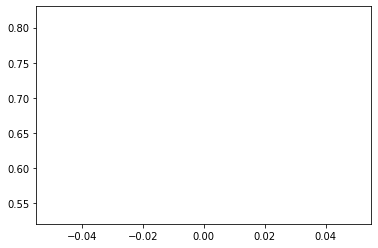

Epoch # 2
Loss[Red] :  tensor(0.4916, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.8047, device='cuda:0')
Test Score[Blue] :  0.8317418981481481
Best Loss & Score :  tensor(0.4916, device='cuda:0', grad_fn=<NllLossBackward>) 0.8317418981481481


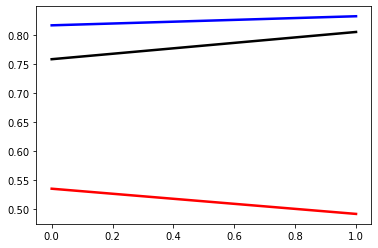

Epoch # 3
Loss[Red] :  tensor(0.4371, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.8203, device='cuda:0')
Test Score[Blue] :  0.8333043981481482
Best Loss & Score :  tensor(0.4371, device='cuda:0', grad_fn=<NllLossBackward>) 0.8333043981481482


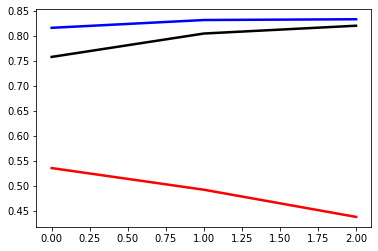

Epoch # 4
Loss[Red] :  tensor(0.4282, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.8438, device='cuda:0')
Test Score[Blue] :  0.8349826388888889
Best Loss & Score :  tensor(0.4282, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


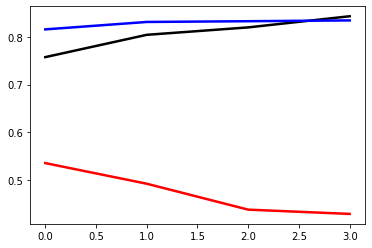

Epoch # 5
Loss[Red] :  tensor(0.4401, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.8516, device='cuda:0')
Test Score[Blue] :  0.8340856481481481
Best Loss & Score :  tensor(0.4282, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


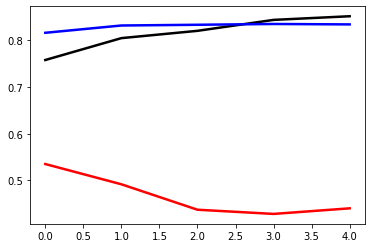

Epoch # 6
Loss[Red] :  tensor(0.4017, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.8359, device='cuda:0')
Test Score[Blue] :  0.8268518518518518
Best Loss & Score :  tensor(0.4017, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


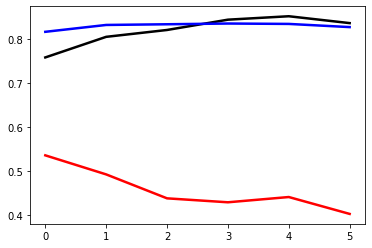

Epoch # 7
Loss[Red] :  tensor(0.3736, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.8906, device='cuda:0')
Test Score[Blue] :  0.828761574074074
Best Loss & Score :  tensor(0.3736, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


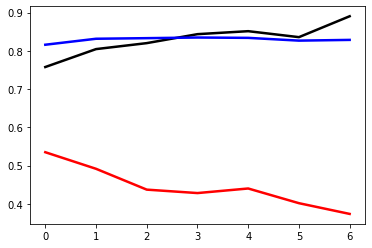

Epoch # 8
Loss[Red] :  tensor(0.3128, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.8906, device='cuda:0')
Test Score[Blue] :  0.8333912037037037
Best Loss & Score :  tensor(0.3128, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


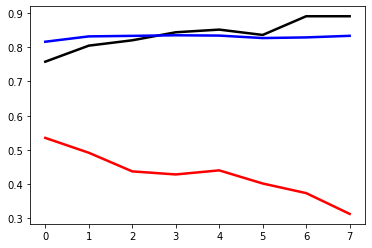

Epoch # 9
Loss[Red] :  tensor(0.3536, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.8750, device='cuda:0')
Test Score[Blue] :  0.8331018518518518
Best Loss & Score :  tensor(0.3128, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


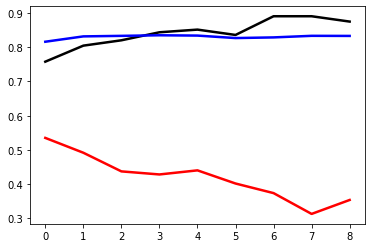

Epoch # 10
Loss[Red] :  tensor(0.2646, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9297, device='cuda:0')
Test Score[Blue] :  0.830931712962963
Best Loss & Score :  tensor(0.2646, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


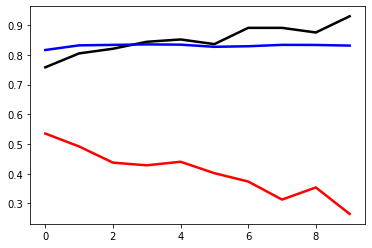

Epoch # 11
Loss[Red] :  tensor(0.2391, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9141, device='cuda:0')
Test Score[Blue] :  0.8319155092592593
Best Loss & Score :  tensor(0.2391, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


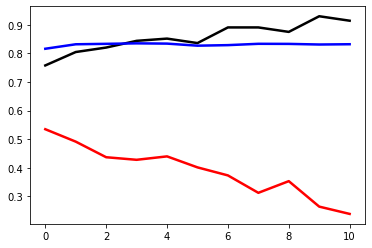

Epoch # 12
Loss[Red] :  tensor(0.2380, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9141, device='cuda:0')
Test Score[Blue] :  0.8307291666666666
Best Loss & Score :  tensor(0.2380, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


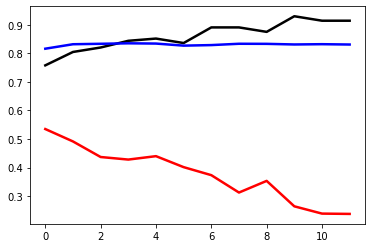

Epoch # 13
Loss[Red] :  tensor(0.1801, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9453, device='cuda:0')
Test Score[Blue] :  0.8337962962962963
Best Loss & Score :  tensor(0.1801, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


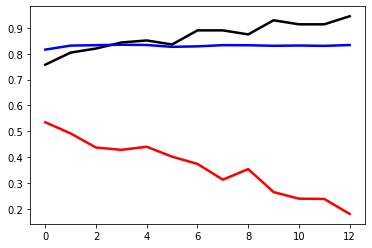

Epoch # 14
Loss[Red] :  tensor(0.2070, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9297, device='cuda:0')
Test Score[Blue] :  0.8315393518518519
Best Loss & Score :  tensor(0.1801, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


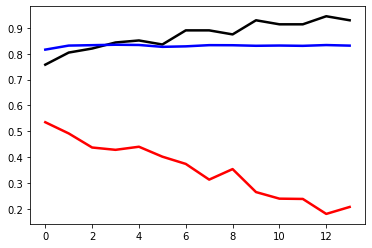

Epoch # 15
Loss[Red] :  tensor(0.1976, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9375, device='cuda:0')
Test Score[Blue] :  0.8306712962962963
Best Loss & Score :  tensor(0.1801, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


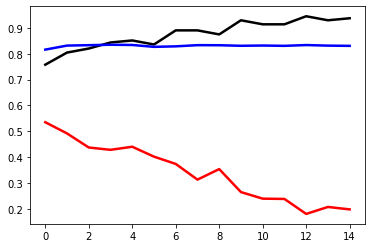

Epoch # 16
Loss[Red] :  tensor(0.2029, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9453, device='cuda:0')
Test Score[Blue] :  0.8297453703703703
Best Loss & Score :  tensor(0.1801, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


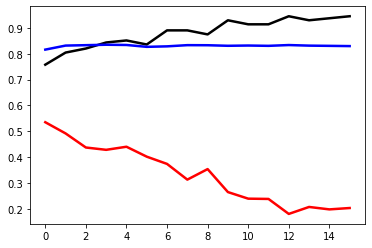

Epoch # 17
Loss[Red] :  tensor(0.2182, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9219, device='cuda:0')
Test Score[Blue] :  0.8289641203703704
Best Loss & Score :  tensor(0.1801, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


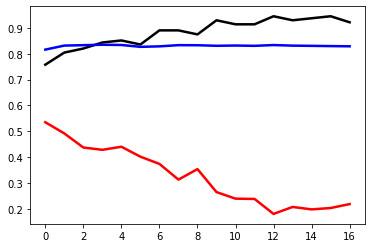

Epoch # 18
Loss[Red] :  tensor(0.1192, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9609, device='cuda:0')
Test Score[Blue] :  0.8297453703703703
Best Loss & Score :  tensor(0.1192, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


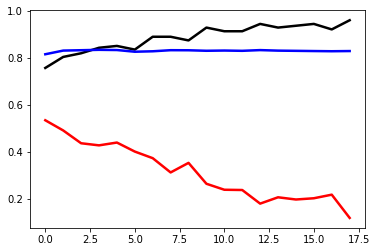

Epoch # 19
Loss[Red] :  tensor(0.1287, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9531, device='cuda:0')
Test Score[Blue] :  0.8318576388888889
Best Loss & Score :  tensor(0.1192, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


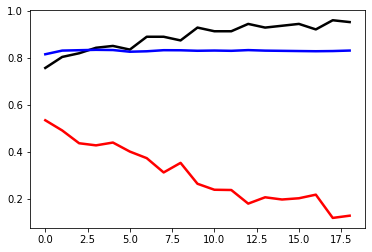

Epoch # 20
Loss[Red] :  tensor(0.1342, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9609, device='cuda:0')
Test Score[Blue] :  0.8328414351851852
Best Loss & Score :  tensor(0.1192, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


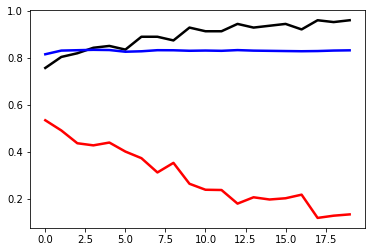

Epoch # 21
Loss[Red] :  tensor(0.1324, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9609, device='cuda:0')
Test Score[Blue] :  0.8343171296296297
Best Loss & Score :  tensor(0.1192, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


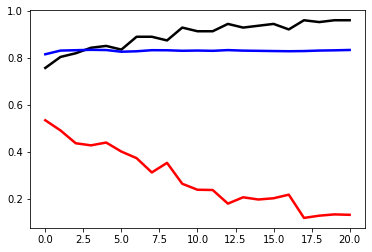

Epoch # 22
Loss[Red] :  tensor(0.0924, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9531, device='cuda:0')
Test Score[Blue] :  0.8319733796296296
Best Loss & Score :  tensor(0.0924, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


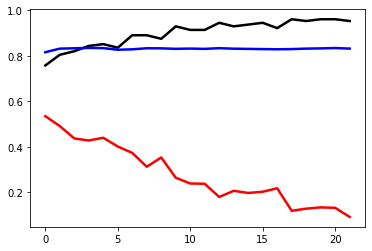

Epoch # 23
Loss[Red] :  tensor(0.0935, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9844, device='cuda:0')
Test Score[Blue] :  0.828761574074074
Best Loss & Score :  tensor(0.0924, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


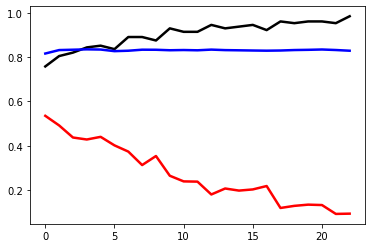

Epoch # 24
Loss[Red] :  tensor(0.1412, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9609, device='cuda:0')
Test Score[Blue] :  0.8309027777777778
Best Loss & Score :  tensor(0.0924, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


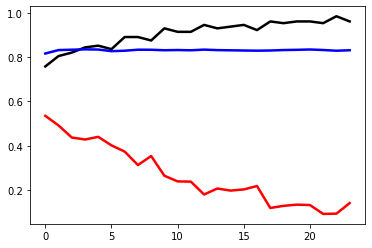

Epoch # 25
Loss[Red] :  tensor(0.0385, device='cuda:0', grad_fn=<NllLossBackward>)
Train Score[Black] :  tensor(0.9922, device='cuda:0')
Test Score[Blue] :  0.8296296296296296
Best Loss & Score :  tensor(0.0385, device='cuda:0', grad_fn=<NllLossBackward>) 0.8349826388888889


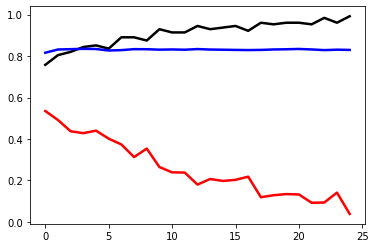

Epoch # 26


KeyboardInterrupt: ignored

In [96]:
# Train Test...
epoch_n = 0
# step = 0
batch_size = 128

# dec_inputs = []
# for i in range(batch_size):
#     dec_inputs.append([2])
# torch_dec_inputs = torch.tensor(dec_inputs).to(device)

loss_vec = []
score_vec_train = []
score_vec_test = []
# Pre-train 하고싶을때... But nVocab 이 pre-train이랑도 같아야한다.
# save_pretrain = f"{data_dir}/save_gpt_pretrain.pth"
# model.decoder.load(save_pretrain)


while(True):
    epoch_n+=1
    print ("Epoch #",epoch_n)
    model.train()
    for i in range(0,pad_enc_inputs.size()[0]-batch_size, batch_size):

        model.zero_grad()

        inputs = pad_enc_inputs[i:i+batch_size].to(device).long() # batch, seq+2
        labels = labels_inputs[i:i+batch_size].to(device).long() # batch
#         labels = labels.reshape(labels.shape[0],1)
        
        
        tag_scores, aux_out = model(inputs)
#         break
        loss = loss_function(tag_scores[:,21], labels)
        loss.backward()
        optimizer.step()
#         break
#     break
    print("Loss[Red] : ",loss)
    loss_vec.append(loss)

    model.eval()
    # Check score
    results = tag_scores[:,:,1]>tag_scores[:,:,0]#>0.5
    A = results[:,21]==labels[:]
    tensor_test_score = A.sum().float() / labels.size()[0]
    #test_score = tensor_test_score.cpu().data
    score_vec_train.append(tensor_test_score)

    # Check Testset Score
    TestScore = GetTestsetAccuracy(pad_enc_inputs_test, labels_inputs_test, batch_size)
    score_vec_test.append(TestScore)
    
    print("Train Score[Black] : ", tensor_test_score)
    print("Test Score[Blue] : ", TestScore)
    print('Best Loss & Score : ', min(loss_vec), max(score_vec_test) )

    plt.plot(score_vec_train, color = 'black', linewidth = 2.5, linestyle = "-")
    plt.plot(score_vec_test, color = 'blue', linewidth = 2.5, linestyle = "-")
    plt.plot(loss_vec, color = 'red', linewidth = 2.5, linestyle = "-")
    plt.show()


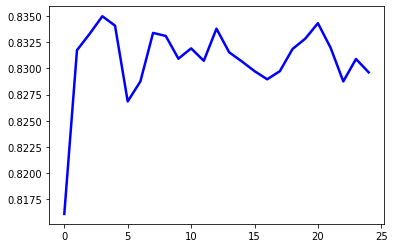

In [111]:
# score_vec_test
plt.plot(score_vec_test[0:25], color = 'blue', linewidth = 2.5, linestyle = "-")
plt.show()

In [104]:
# Demo
model.eval()
test_inputs = ["너무 재밌는 영화! 역대급 인생작품이다.", "재미가 1도 없음 ㅡㅡ 발로 만들었나?", "완전 내취향... 최고의 작품! 꼭 보세요 두번 보세요 세번 보세요", "유튜브 B급감성 동영상만도 못한 쓰레기영화. 이걸 영화라고 만들었나? 어이상실", "내가 만들어도 이거보단 낫겠다ㅋ"]
print("True : 긍정 / False : 부정")
for test_input in test_inputs:
    tokenized = tagger.morphs(test_input)
    
    input_ = TEXT.numericalize([tokenized], device=device)
    np_enc_input=np.zeros((20+2))
    np_enc_input[0]=2
    np_enc_input[1:input_[0].cpu().data.numpy().shape[0]+1] = (input_[0]).cpu().data.numpy()+4
    np_enc_input[input_[0].cpu().data.numpy().shape[0]+1] = 3
    input_demo = torch.tensor(np_enc_input).long().reshape(1,input_demo.size()[1]).to(device)
    
    prediction, _ = model(input_demo)

    results_test = prediction[:,:,1]>prediction[:,:,0]
    print(test_input)
    print(results_test[:,21])

    results_test = prediction[:,:,1]>prediction[:,:,0]
    A = results_test[:,21]==labels_test[:]
    tensor_test_score = A.sum().float() / labels_test.size()[0]
    score_vec_test.append(tensor_test_score.cpu().data.numpy()/1)

    print(sum(score_vec_test) / len(score_vec_test))

True : 긍정 / False : 부정
너무 재밌는 영화! 역대급 인생작품이다.
tensor([True], device='cuda:0')
0.6977308723196881
재미가 1도 없음 ㅡㅡ 발로 만들었나?
tensor([False], device='cuda:0')
0.7029424090038314
완전 내취향... 최고의 작품! 꼭 보세요 두번 보세요 세번 보세요
tensor([True], device='cuda:0')
0.6910281308851224
유튜브 B급감성 동영상만도 못한 쓰레기영화. 이걸 영화라고 만들었나? 어이상실
tensor([False], device='cuda:0')
0.696177662037037
내가 만들어도 이거보단 낫겠다ㅋ
tensor([False], device='cuda:0')
0.7011583561020036


In [0]:
score_vec_test

In [18]:
inputs

tensor([[   2,   13,  112,  ...,    0,    0,    0],
        [   2,   51,   39,  ...,    0,    0,    0],
        [   2,  198,   19,  ...,    0,    0,    0],
        ...,
        [   2,   69,   11,  ...,    0,    0,    0],
        [   2, 1639,  130,  ...,    0,    0,    0],
        [   2,   35,   20,  ...,    0,    0,    0]], device='cuda:0')

In [0]:
# Check testset score
model.eval()
sum_score_test = []
score_vec_test = []
for i in range(0,pad_enc_inputs_test.size()[0]-batch_size, batch_size):

    inputs_test = pad_enc_inputs_test[i:i+batch_size].to(device).long() # batch, seq+2
    labels_test = labels_inputs_test[i:i+batch_size].to(device).long() # batch
    tag_scores_test = model(inputs_test)
    
    results_test = tag_scores_test[:,:,1]>tag_scores_test[:,:,0]
    A = results_test[:,21]==labels_test[:]
    tensor_test_score = A.sum().float() / labels_test.size()[0]
    score_vec_test.append(tensor_test_score.cpu().data.numpy()/1)
    
print("Testset Mean Score : ", sum(score_vec_test) / len(score_vec_test))

너무재밌따
tensor(False, device='cuda:0')
재미가 없어요
tensor(False, device='cuda:0')


In [22]:
prediction

(tensor([[[-0.0895,  0.2081],
          [ 0.2274, -0.0057],
          [-0.3027,  0.2910],
          [ 0.4238, -0.1319],
          [ 1.7285, -1.1842],
          [ 0.9875, -0.5918]]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[[-0.4943,  0.3618, -0.0947,  ..., -0.0044, -0.3159, -0.2981],
          [-0.6119,  0.2807, -0.1293,  ..., -0.1193, -0.2578, -0.1254],
          [-0.2920,  0.0348, -0.1880,  ...,  0.1132, -0.2555, -0.1804],
          [-0.1089,  0.0357,  0.1866,  ...,  0.0298,  0.1665, -0.1303],
          [-0.0963,  0.3287, -0.1473,  ..., -0.3983,  0.3833, -0.2628],
          [-0.0540,  0.4483, -0.2817,  ..., -0.2861,  0.4510, -0.3381]]],
        device='cuda:0', grad_fn=<AddBackward0>))

In [0]:
# Fine tune NSMC dataset

DATA_PATH = '/content/gdrive/My Drive/Colab Notebooks' # Data Path
tagger = Mecab()
USE_CUDA = torch.cuda.is_available()
device = 'cuda' # or 'cpu'

TEXT = Field(tokenize=tagger.morphs,lower=True,include_lengths=False,batch_first=True)
LABEL = Field(sequential=False,use_vocab=True,unk_token=None)

train_data, test_data = TabularDataset.splits(path=DATA_PATH,
 train='ratings_train.txt',
 test='ratings_test.txt',
 format='tsv', 
 skip_header=True, 
 fields=[('id',None),('text',TEXT),('label',LABEL)], 
 filter_pred = lambda x: True if len(x.text) > 1 else False)

TEXT.build_vocab(train_data,min_freq=2)
LABEL.build_vocab(train_data)

train_loader, test_loader = BucketIterator.splits((train_data,test_data),sort_key=lambda x:len(x.text), sort_within_batch=True,
 repeat=False,shuffle=True, batch_size=1,device=device)

max_enc_length = 20
enc_inputs = []
dec_inputs = []

for bat in train_loader:
    inputs, labels = bat.text, bat.label.float()
    
    if (inputs.size()[1]>max_enc_length): # skisp size > 50
        continue
    np_enc_input=np.zeros((max_enc_length+2))
    np_enc_input[0]=2
    np_enc_input[1:inputs[0].cpu().data.numpy().shape[0]+1] = (inputs[0]+4).cpu().data.numpy()+4
    np_enc_input[inputs[0].cpu().data.numpy().shape[0]+1] = 3
    #torch_enc_input = torch.tensor(np_enc_input)
    #print(np_enc_input)
        
    enc_inputs.append(np_enc_input)
    dec_inputs.append(labels[0])
pad_enc_inputs = torch.tensor(enc_inputs)
labels_inputs = torch.tensor(dec_inputs)

# dec_inputs = torch.tensor([2])
print("[Train set]")
print('encoder input size : ', pad_enc_inputs.size())
print('labels size : ', labels_inputs.size())


## For Test Set Read
enc_inputs_test = []
dec_inputs_test = []
for bat in test_loader:
    inputs_test, labels_test = bat.text, bat.label.float()
    if (inputs_test.size()[1]>max_enc_length): # skisp size > 50
        continue
    np_enc_input=np.zeros((max_enc_length+2))
    np_enc_input[0]=2
    np_enc_input[1:inputs_test[0].cpu().data.numpy().shape[0]+1] = (inputs_test[0]+4).cpu().data.numpy()+4
    np_enc_input[inputs_test[0].cpu().data.numpy().shape[0]+1] = 3
    enc_inputs_test.append(np_enc_input)
    dec_inputs_test.append(labels_test[0])
pad_enc_inputs_test = torch.tensor(enc_inputs_test)
labels_inputs_test = torch.tensor(dec_inputs_test)

print("[Test set]")
print('encoder input size : ', pad_enc_inputs_test.size())
print('labels size : ', labels_inputs_test.size())
print('Done!')